In [85]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import scipy.constants as sc
from scipy.fft import fft,ifft,fftfreq, dct, idct
import matplotlib.pyplot as plt
from numpy import linalg as LA
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm_notebook
import mpl_toolkits.mplot3d as mplot3d
import scipy.special as ss
from scipy.integrate import quad, dblquad
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns
import os
import datetime
nu_and_nu_d_data = pd.read_csv("C:\\Users\\david\\Documents\\data for fig5b from flattened BEC paper.csv", header = None)

In [ ]:
class split_step_method():
    def __init__(self,N,Nz,box,
                 r_plane,gamma_sin,
                 D_sin_res,D_sin_range_start,
                 D_sin_range_end,
                 N_iterations, ##inputs for fixed gamma
                 
                 D_res_purely_dipolar_stability,
                 D_range_purely_dipolar_stability,
                 gamma_res_purely_dipolar_stability_low_gamma,
                 gamma_res_purely_dipolar_stability_high_gamma,
                 gamma_range_start_purely_dipolar_stability,
                 gamma_range_end_purely_dipolar_stability_low_gamma,
                 gamma_range_end_purely_dipolar_stability_high_gamma,
                 p_max_dipolar, ##inputs for purely dipolar gas
                 
  
                 
                 
                 
                 
                 
                 Nu_res,Nu_range,Nu_d_res,Nu_d_range,
                 p_max_nu, ##inputs for non-purely dipolar gas
                 
                 b = 25, use_cosine_transform = False,
                 quasi_2D = False, Hankel_3D_without_cosine = False,
                 box_potential=False,
                 get_nu_stability_boundary=False,
                 purely_dipolar_stability=False,
                 get_plots_with_fixed_gamma=False,
                 
                 
                 gs = 0, ##dimensionless contact factor
              

                 m = 2.7774e-25, ##mass of erbium atom
                 w=100*np.pi, ##radial frequency
                 Ao = 5.29*1e-11, #Bohr radius
                 
                 mu =6.98, ##dipole moment of erbium
                 mu_B =9.2740100783e-24, ##Bohr magneton
                 
                 No = 4.5*1e4, #number of particles
                 ):

        for local in locals().copy(): 
            ## equivalent of writing self.gamma = gamma,self.b = b etc.
            ## without having to rewrite it.
            exec('self.' + local +  ' = locals()[local]')

        if self.use_cosine_transform + self.quasi_2D + self.Hankel_3D_without_cosine > 1: 
            raise AttributeError('Can only do one from Quasi, Cosine or full 3D.')
        if self.purely_dipolar_stability + self.get_nu_stability_boundary + self.get_plots_with_fixed_gamma >1:
            raise AttributeError('Can only do one from stability for purely dipolar, stability for contact and dipolar, and plots with fixed gamma.')

        if self.purely_dipolar_stability:
            print('Doing a stability analysis of a purely dipolar gas')

        if self.get_nu_stability_boundary:
            print('Doing a stability analysis of a dipolar gas with contact interactions')     

        if self.get_plots_with_fixed_gamma:
            print('Calculating the ground state of purely dipolar gas for various dipole strengths while fixing gamma,')
        if self.box_potential:
            print("with a circular box potential in the r direction.")
        else:
            print("with a harmonic potential in the r direction.")

        if self.use_cosine_transform:
            print("Using Hankel with Cosine transform.")
        if self.Hankel_3D_without_cosine:
            print("Using Hankel without Cosine transform.")
        if self.quasi_2D:
            print("Using Quasi 2D approximation.")



        self.initialise_variables() ## variables not dependent on gamma

        if get_plots_with_fixed_gamma:

            self.update_variables_based_on_gamma()

            self.psi,self.psis_at_z_0,self.psis_at_r_0,self.psis_near_edge_of_box,self.final_psis,self.E_list,self.E_index_list = self.split_step_method_loop()

            self.save_boolean = bool(int(input('Save Data?')))
            if self.save_boolean:
                folder_name = 'plots for gamma='+str(self.gamma)+' '+str(datetime.datetime.today().date())
                if self.box_potential:
                    self.path = 'C://Users/david/OneDrive/Documents/UNI/BEC project/diagrams/box potential stability plots/Plots with fixed gamma box case/'+folder_name
                else:
                    self.path = 'C://Users/david/OneDrive/Documents/UNI/BEC project/diagrams/harmonic stability plots/Plots with fixed gamma harmonic case/'+folder_name 
                if not os.path.isdir(self.path):
                    os.mkdir(self.path)
                print('got here')
                file_path_for_psis_at_z_0 = self.path+'/'+'data for psis at z=0,gamma='+str(self.gamma)
                file_path_for_psis_at_r_0 = self.path+'/'+'data for psis at r=0,gamma='+str(self.gamma)
                file_path_for_psis_near_edge_of_box = self.path+'/'+'data for psis at r='+str(self.r_plane)+',gamma='+str(self.gamma)
                file_path_for_final_psis = self.path+'/''list of final psis,gamma = '+str(self.gamma)

                self.psis_at_z_0 = pd.DataFrame(data=self.psis_at_z_0,index=self.r[:,0],columns =self.Ds)
                self.psis_at_r_0 = pd.DataFrame(data=self.psis_at_r_0,index=self.z[0,:],columns =self.Ds)
                self.psis_near_edge_of_box = pd.DataFrame(data=self.psis_near_edge_of_box,
                                                             index=self.z[self.near_edge_of_box_index,:],columns =self.Ds)


                self.psis_at_z_0.to_excel(file_path_for_psis_at_z_0+'.xlsx')
                self.psis_at_r_0.to_excel(file_path_for_psis_at_r_0+'.xlsx')
                self.psis_near_edge_of_box.to_excel(file_path_for_psis_near_edge_of_box+'.xlsx')
                np.save(file_path_for_final_psis+'.npy',self.final_psis)


            self.plot_results_from_split_step_method(self.psi,self.psis_at_z_0,
                                                     self.psis_at_r_0,self.psis_near_edge_of_box,
                                                     self.E_list,self.E_index_list)

        if get_nu_stability_boundary:


            self.stability_boundary_nu_values,self.stability_boundary_nu_dipole_values,self.final_psi_list_nu = self.get_stability_boundary_loop()


            self.save_boolean = bool(int(input('Save Data?')))
            if self.save_boolean:
                folder_name = 'Nu_stability_boundary '+str(datetime.datetime.today().date())
                if self.box_potential:
                    self.path = 'C://Users/david/OneDrive/Documents/UNI/BEC project/diagrams/box potential stability plots/Nu stability boundaries box case/'+folder_name
                else:
                    self.path = 'C://Users/david/OneDrive/Documents/UNI/BEC project/diagrams/harmonic stability plots/Nu stability boundaries harmonic case/'+folder_name 
                if not os.path.isdir(self.path):
                    os.mkdir(self.path)

            file_path_for_stability_boundary_data = self.path+'/'+'stability_boundary_with_contact_interactions_data'
            file_path_for_final_psi_list_nu = self.path+'/'+'final_psi_list, with nu_d and nu specified respectively before each psi'


            self.stability_boundary_data = np.zeros((2,len(self.stability_boundary_nu_values)))
            self.stability_boundary_data[0,:] = self.stability_boundary_nu_values
            self.stability_boundary_data[1,:] = self.stability_boundary_nu_d_values
            self.stability_boundary_data = pd.DataFrame(stability_boundary_data,index = ['Nu_values','Nu_d values'])


            self.stability_boundary_data.to_excel(file_path_for_stability_boundary_data+'.xlsx')

            self.plot_results_from_stability_boundary_code(self.stability_boundary_nu_values,
                                                           self.stability_boundary_nu_dipole_values)


        if purely_dipolar_stability:
            self.stability_matrix,self.stability_boundary_D_values,self.ground_state_energy_values,self.final_psi_list = self.split_step_method__stability_code()




            self.save_boolean = bool(int(input('Save Data?')))
            if self.save_boolean:
                folder_name = 'Purely_Dipolar_stability_boundary '+str(datetime.datetime.today().date())
                if self.box_potential:
                    self.path = 'C://Users/david/OneDrive/Documents/UNI/BEC project/diagrams/box potential stability plots/Purely Dipolar box case/'+folder_name
                else:
                    self.path = 'C://Users/david/OneDrive/Documents/UNI/BEC project/diagrams/harmonic stability plots/Purely Dipolar harmonic case/'+folder_name
                if not os.path.isdir(self.path):
                    os.mkdir(self.path)

                file_path_for_stability_boundary_data_purely_dipolar = self.path+'/'+'stability_boundary_for purely dipolar gas_data'
                file_path_for_stability_matrix = self.path+'/'+'stability_matrix'
                file_path_for_ground_state_energy_values = self.path+'/'+'ground_state_energy_values' 
                file_path_for_final_psi_list = self.path+'/'+'final_psis, with D and gamma specified respectively before each psi'

                self.stability_boundary_data_purely_dipolar = np.zeros((2,len(self.stability_boundary_D_values)))
                self.stability_boundary_data_purely_dipolar[0,:] = self.gammas
                self.stability_boundary_data_purely_dipolar[1,:] = self.stability_boundary_D_values
                self.stability_boundary_data_purely_dipolar = pd.DataFrame(self.stability_boundary_data_purely_dipolar,index = ['gamma values','D values'])

                self.stability_boundary_data_purely_dipolar.to_excel(file_path_for_stability_boundary_data_purely_dipolar+'.xlsx')

                np.save(file_path_for_final_psi_list+'.npy',self.final_psi_list)
                np.save(file_path_for_stability_matrix+'.npy',self.stability_matrix)
                np.save(file_path_for_ground_state_energy_values+'.npy',self.ground_state_energy_values)


            self.plot_results_from_stability_code(self.stability_matrix,
                                                  self.stability_boundary_D_values,
                                                  self.gammas,
                                                  self.ground_state_energy_values)





    def plot_results_from_split_step_method(self,psi,psis_at_z_0,psis_at_r_0,psis_near_edge_of_box,E_list,E_index_list,):


        if not self.box_potential:
            r_cutoff = 20
            z_cutoff = np.max(np.abs(self.z))/2
        else:
            r_cutoff = self.b ##for box plot, can plot all of r
            z_cutoff = np.max(np.abs(self.z))

        diff = psi - self.gnd_state

        plt.plot(np.asarray(E_index_list),np.asarray(E_list))
        plt.xlabel('iteration number')
        plt.ylabel('energy')
        plt.show() ##shows energy against iteration number for the last psi calculated

        if self.quasi_2D:
            plt.plot(self.r,psi, label ="numerical ground state")
            plt.plot(self.r,self.gnd_state,'r--', label ="true ground state")
            #plt.plot(r,TF_dipolar,'m--',label = "Dipolar Thomas Fermi solution")
            #plt.plot(r,TF_contact,'g--',label = "Contact Thomas Fermi solution")
            plt.legend()
            plt.xlabel('r/xs')
            plt.ylabel('psi')
            #plt.ylim(0,20)
            #plt.xlim(0,10)
            plt.show() ##plots psi against r

            plt.plot(self.r,100*diff/np.max(psi),label="diff in % of max psi")
            plt.xlabel('r position')
            plt.ylabel('diff/% of max of psi')
            #plt.ylim(-1,1)
            plt.xlim(0,10)
            plt.legend()
            plt.title('diff/%')
            plt.show() # plots diff in terms of % of max psi


        else:
            fig,ax = plt.subplots()
            ax.contour(self.r,self.z,np.abs(psi)) ##contour plot of psi in r-z plane
            ax.set_title('contour plot of psi')
            #ax.set_ylim(-1,1)
            #ax.set_xlim(0,box)
            ax.set_xlabel('r position')
            ax.set_ylabel('z position')
            plt.show()

            bools =(np.abs(self.r) <= r_cutoff)*(np.abs(self.z) <=z_cutoff)
            ##boolean vector used to manually set limits on the axes

        if self.use_cosine_transform:
            n_1 = np.sum(bools[:,self.Nz-1]) ## number of r coords with value less than r_cutoff
            n_2 = self.Nz - np.sum(bools[0,:]) ## number of z coords with value less than z_cutoff
            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.plot_surface(self.r[0:n_1,n_2:(self.Nz-1)],
                                self.z[0:n_1,n_2:(self.Nz-1)],
                                np.abs(psi)[0:n_1,n_2:(self.Nz-1)],cmap='jet')
            ax.set_title('Psi')
            ax.set_xlabel('r position')
            ax.set_ylabel('z position')
            ax.set_zlabel('psi')
            plt.show() ##3D plot of psi in r-z plane

            #plt.plot(self.r[:,0],self.gnd_state[:,self.Nz-1])
            plt.plot(self.r[:,0],np.abs(psis_at_z_0))
            #plt.plot(self.r[:,0],TF_contact[:,self.Nz-1], label="Thomas Fermi for contact, z=0")
            #plt.plot(self.r[:,0],TF_quasi[:,self.Nz-1], label="Thomas Fermi for purely dipolar, z=0")
            plt.title('psi in z=0 plane, gamma = '+str(self.gamma))
            plt.legend(np.append('z=0, D=0',['z=0, D = '+str(s) for s in np.round(self.Ds[1:],1)]))
            plt.xlabel('r position')
            plt.ylabel('psi')
            if self.save_boolean:
                plt.savefig(self.path+'/'+'psi in z=0 plane, gamma = '+str(self.gamma)+'.png')
            plt.show() ##plots psi at z=0 for various D values        


            #plt.plot(self.z[0,:],np.abs(self.gnd_state[0,:]))
            plt.plot(self.z[0,:],np.abs(psis_at_r_0))
            #plt.plot(z(gamma)[0,:],np.abs(TF_contact[0,:]),label="Thomas Fermi for contact,z=0")
            plt.title('psi in r=0 plane, gamma = '+str(self.gamma))
            #plt.xlim(0,5)
            plt.legend(np.append('r=0, D=0',['r=0, D = '+str(s) for s in np.round(self.Ds[1:],1)]))
            plt.xlabel(' z position')
            plt.ylabel('psi')
            if self.save_boolean:
                plt.savefig(self.path+'/'+'psi in r=0 plane, gamma = '+str(self.gamma)+'.png')
            plt.show() ##plots psi at r = 0 for various D values


            plt.plot(self.z[0,:],np.abs(self.gnd_state[0,:]))
            plt.plot(self.z[0,:],np.abs(psis_near_edge_of_box))

            plt.title('psi in r='+str(self.r_plane)+' plane, gamma = '+str(self.gamma))
            plt.legend(np.append('r='+str(self.r_plane)+'D=0',['r='+str(self.r_plane)+', D = '+str(s) for s in np.round(self.Ds[1:],1)]))
            plt.xlabel(' z position')
            plt.ylabel('psi')
            if self.save_boolean:
                plt.savefig(self.path+'/'+'psi in r='+str(self.r_plane)+' plane, gamma = '+str(self.gamma)+'.png')
            plt.show() ##plots psi for a given r=const plane 


##this is plotting diff in the r=0 plane and the z=0 plane for a specific psi, not needed at the moment 
#             plt.plot(self.r[:,0],100*diff[:,self.Nz-1]/np.max(psi),label="diff in r direction, z=0")
#             plt.plot(self.z[0,:],100*diff[0,:]/np.max(psi),label="diff in z direction, r=0")
#             plt.title('diff/% of psi for r=0 and z=0 to ground state with no interactions')
#             #plt.xlim(0,6)
#             plt.xlabel('r,z')
#             plt.ylabel('difference in % of max psi"')
#             plt.legend()
#             plt.show()  

        if self.Hankel_3D_without_cosine: ###not really using this, cosine transform is better


            n_1 = np.sum(bools[:,self.midway_index_z]) ## number of r coords with value less than r_cutoff
            n_2 = np.sum(bools[0,:]) ## number of z coords with value less than z_cutoff            
            z_coord_i = int(self.midway_index_z-n_2/2)
            z_coord_f = int(self.midway_index_z+n_2/2)
            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.plot_surface(self.r[0:n_1,z_coord_i:z_coord_f],
                            self.z[0:n_1,z_coord_i:z_coord_f],
                            np.abs(psi)[0:n_1,z_coord_i:z_coord_f],
                            cmap='jet')
            ax.set_title('Psi')
            ax.set_xlabel('r position')
            ax.set_ylabel('z position')
            ax.set_zlabel('psi')
            plt.show()

            plt.plot(self.r[:,0],self.gnd_state[:,self.midway_index_z])
            plt.plot(self.r[:,0],np.abs(psis_at_z_0))
            #plt.plot(r[:,0],TF_contact[:,midway_index_z], label = "Thomas Fermi, z=1")
            #plt.plot(r[:,0],TF_quasi[:,midway_index_z], label = "Thomas Fermi, z=0")
            plt.title('psi in z=0 plane')
            plt.xlim(0,r_cutoff)
            plt.legend(np.append('non interacting ground state, z=0',['z=0, D = '+str(s) for s in np.round(self.Ds,1)]))
            plt.xlabel('r position')
            plt.ylabel('psi')
            plt.show()        

            plt.plot(self.z[0,:],np.abs(np.rot90(psi)))
            plt.plot(self.z[0,:],np.abs(self.gnd_state[0,:]),label = "ground state, r=0")
            plt.title('psi in z direction, r=0')
            plt.xlim(0,r_cutoff)
            plt.legend()
            plt.xlabel(' z position')
            plt.ylabel('psi')
            plt.show()  

#             plt.plot(self.r[:,0],100*diff[:,self.midway_index_z]/np.max(psi),label="diff in r direction, z=0")
#             plt.plot(self.z[0,:],100*diff[0,:]/np.max(psi),label="diff in z direction, r=0")
#             plt.title('diff/% of psi for r=0 and z=0 to ground state with no interactions')
#             plt.xlabel('r,z')
#             plt.ylabel('difference in % of max psi"')
#             plt.legend()
#             plt.show()  

    def plot_results_from_stability_code(self,stability_matrix,boundary_D_values,boundary_gamma_values,Energy_values):

        plt.plot(boundary_gamma_values,boundary_D_values,label= 'stability boundary for $g_{s}$ ='+str(0))
        plt.xlabel('$\gamma$')
        plt.ylabel('D/'+'$\sqrt{\gamma}$')
        plt.grid()
        plt.legend()
        plt.ylim(0,np.max(self.Ds))
        plt.xlim(self.gamma_range_start_purely_dipolar_stability,self.gamma_range_end_purely_dipolar_stability_high_gamma)
        if self.save_boolean:
            plt.savefig(self.path+'/'+'purely dipolar stability boundary'+'.png')
        plt.show() ##plots the stability boundary for D against gamma

        plot_boolean = bool(input('just stability boundary plot?'))
        if not plot_boolean:
            rounded_Ds = np.round(self.Ds,1)
            rounded_gammas = np.round(self.gammas,1)
            df = pd.DataFrame(np.rot90(stability_matrix),index = np.max(rounded_Ds)-rounded_Ds,columns=rounded_gammas)
            sns.heatmap(df)
            plt.xlabel('$\gamma$')
            plt.ylabel('$D/\sqrt{gamma}')
            plt.show()

            gamma_res_total = self.gamma_res_purely_dipolar_stability_low_gamma+self.gamma_res_purely_dipolar_stability_high_gamma
            Ds_2D = self.Ds.reshape(1,-1).repeat(gamma_res_total,0)
            gammas_2D = self.gammas.reshape(-1,1).repeat(self.D_res_purely_dipolar_stability,1)

            df2 = pd.DataFrame(np.rot90(Energy_values),index = np.max(rounded_Ds)-rounded_Ds,columns=rounded_gammas)
            sns.heatmap(df2)
            plt.xlabel('$\gamma$')
            plt.ylabel('$D/\sqrt{gamma}')
            plt.show()


            plt.plot(Ds_2D[int(gamma_res_total/2),:],
                     Energy_values[int(gamma_res_total/2),:],
                     label='Energy for gamma ='+str(gammas_2D[0,int(gamma_res_total/2)]) + 'unstable regions are given E=0' )
            plt.grid()
            plt.legend()
            plt.xlabel('D')
            plt.ylabel('E/$\hbar\omega_{z}')
            plt.show()



    def plot_results_from_stability_boundary_code(self,nu_values,nu_d_values):

        nu_and_nu_d_data = pd.read_csv("C:\\Users\\david\\Documents\\data for fig5b from flattened BEC paper.csv", header = None)
        nu_and_nu_d_data = nu_and_nu_d_data.values

        plt.plot(nu_and_nu_d_data[0,:],nu_and_nu_d_data[1,:])
        plt.plot(nu_values[0,:],np.transpose(nu_d_values))
        plt.xlabel('nu')
        plt.ylabel('nu_d')
        plt.grid()
        plt.legend(np.append('Data from Paper',['gamma = '+str(s) for s in self.gammas_for_nu_boundary]))
        plt.xlim(0,self.Nu_range)
        plt.ylim(0,self.Nu_d_range)
        plt.show()



    def split_step_method_loop(self,):

        self.Ds = np.linspace(self.D_sin_range_start,self.D_sin_range_end,self.D_sin_res)

        self.initialise_psi()
        psi = self.psi.copy() ##so you don't need to keep writing self for psi
        final_psis = np.zeros((len(self.alpha),self.Nz,self.D_sin_res)) #3d array to add psis to
        psis_at_z_0 = np.zeros((len(self.alpha),self.D_sin_res))
        psis_at_r_0 = np.zeros((self.Nz,self.D_sin_res))
        psis_near_edge_of_box = np.zeros((self.Nz,self.D_sin_res)) ##setting up empty arrays to add values into



        for n in tqdm_notebook(range(self.D_sin_res),leave = False,
                              desc = 'Iterating over D'):
            self.D = self.Ds[n] ##iterates over different values of D for each n
            E_list = []
            E_index_list = []
            exp_T = self.initialise_exp_T(E_list,)
            trig = False
            loop_trig = False
            dt = self.dt(E_list)
            for i in tqdm_notebook(range(self.N_iterations),leave = False,
                                  desc = 'Iterating over Imaginary Time'):  ##split step loop
                if not loop_trig:

                    if i%10==0: ##adds energy to list every tenth iteration, then checks for convergence
                        E_list.append([self.ENERGY(psi,self.gamma,self.gs,self.J)])
                        E_index_list.append([i])

                        exp_T = self.initialise_exp_T(E_list,)
                        if not trig:
                            new_dt = self.dt(E_list)
                            trig = abs(new_dt) < abs(dt) ###once dt drops, it stays there
                            dt = new_dt ##when near convergence, dt drops

                    if self.quasi_2D:
                        psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies second half of potential
                        psi = exp_T*self.do_Hankel_transform(psi,self.J) ## applies kinetic in (cosine) fourier and bessel space
                        psi = self.do_inverse_Hankel_transform(psi,self.J)  ##transforms back to position space
                        psi /= self.Norm_r(psi)
                        psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                        psi /= self.Norm_r(psi)

                    if self.use_cosine_transform:   
                        psi = np.exp(-0.5j*dt*self.V(psi,J=self.J,gs=self.gs))*psi ##applies s\econd half of potential
                        psi = exp_T*self.do_Hankel_transform(dct(psi,1,axis=1),self.J) ## applies kinetic in (cosine) fourier and bessel space   
                        psi = idct(self.do_inverse_Hankel_transform(psi,self.J),1,axis=1)  ##transforms back to position space
                        psi /= self.Norm_r(psi)
                        psi = np.exp(-0.5j*dt*self.V(psi,J=self.J,gs=self.gs))*psi ##applies second half of potential              
                        psi /= self.Norm_r(psi)
                        #if (psi[0,self.Nz-1]/np.max(psi))<0.01: ##breaks if there is a spike away from origin
                            
                         #   loop_trig = True

                    if self.Hankel_3D_without_cosine:
                        psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies half the potential
                        psi = exp_T*self.do_Hankel_transform(fft(psi,axis=1),self.J) ##applies kinetic in k space
                        psi = ifft(self.do_inverse_Hankel_transform(psi,self.J),axis=1) ##transforms back to position space
                        psi /= self.Norm_r(psi) ##normalising, needs to be right normalisation for psi dependent V
                        psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies second half of potential
                        psi /= self.Norm_r(psi) ##normalises
                        #if (psi[0,self.midway_index_z]/np.max(psi))<0.01:###breaks if there is a spike away from origin

                         #   loop_trig = True

                    if np.isnan(psi).any() or np.min(E_list)<0: #or np.max(E_list)>E_list[0]: 
                        print('not converged')
                        loop_trig = True ##stops the loop early if there is a collapse to nan or energy becomes negative,
                                ###or if energy becomes larger than the initial guess (spike), not sure about this last criteria

                    if self.E_conv(E_list,criteria=1e-8): 
                        
                        loop_trig = True
#             if not self.E_conv(E_list,criteria=1e-8):
#                 break
            if self.Hankel_3D_without_cosine:
                psis_at_z_0[:,n] = psi[:,self.midway_index_z]
            if self.use_cosine_transform:
                psis_at_z_0[:,n]=psi[:,self.Nz-1]
            psis_at_r_0[:,n] = psi[0,:]
            psis_near_edge_of_box[:,n] = psi[self.near_edge_of_box_index,:] 
            final_psis[:,:,n] = psi


        return psi,psis_at_z_0,psis_at_r_0,psis_near_edge_of_box,final_psis,E_list,E_index_list

    def split_step_method__stability_code(self,p_max = 15000):
        #####could set p_max to be a function of gamma?


        self.Ds = np.linspace(0,self.D_range_purely_dipolar_stability,
                              self.D_res_purely_dipolar_stability)

        low_gammas = np.linspace(self.gamma_range_start_purely_dipolar_stability,
                                  self.gamma_range_end_purely_dipolar_stability_low_gamma,
                                  self.gamma_res_purely_dipolar_stability_low_gamma)
        high_gammas = np.linspace(self.gamma_range_end_purely_dipolar_stability_low_gamma+10,
                                 self.gamma_range_end_purely_dipolar_stability_high_gamma,
                                  self.gamma_res_purely_dipolar_stability_high_gamma)
        self.gammas = np.append(low_gammas,high_gammas)


        stability_matrix = np.zeros([len(self.gammas),
                                     self.D_res_purely_dipolar_stability])

        self.final_Energy_matrix = np.zeros([len(self.gammas),
                                             self.D_res_purely_dipolar_stability])
        self.final_psi_list = []


        stability_boundary_D_values = np.zeros((len(self.gammas)))
        #self.index_to_start_iterating_over_D = 0 
        index_of_previous_boundary_D_value = 0
        latest_boundary_D_value = 0

        for i in tqdm_notebook(range(len(self.gammas)),leave = False,
                              desc = 'Iterating over gamma'):
            stability_boundary_reached = False
            self.gamma = self.gammas[i]
            self.update_variables_based_on_gamma()
            if self.box_potential:
                Ds_before_transformation = self.Ds*np.sqrt(self.gamma)*27/8
            else:
                 Ds_before_transformation = self.Ds

            for j in tqdm_notebook(range(self.D_res_purely_dipolar_stability),leave = False,
                                  desc = 'Iterating over D'):  

                if not stability_boundary_reached:
                    if i>0:
                        index_of_previous_boundary_D_value = np.argmin(np.abs(Ds_before_transformation-latest_boundary_D_value)) - 1
                        if index_of_previous_boundary_D_value<0:
                            index_of_previous_boundary_D_value = 0
                    ##minus one to make sure the starting value is never higher than the previous boundary D value

                    self.D = Ds_before_transformation[index_of_previous_boundary_D_value+j] ##iterates through different values of D and gamma

                    self.initialise_psi() ##sets initial guess
                    psi = self.psi.copy()

                    E_list = []
                    isConv=False
                    p=0
                    exp_T = self.initialise_exp_T(E_list,)
                    self.split_step_method_dt_trig = False
                    dt = self.dt(E_list)
                    while not isConv and p<self.p_max_dipolar: ##loops until convergence or p=p_max
                        if p%10==0:
                            E_list.append(self.ENERGY(psi,gamma = self.gamma,gs=self.gs,J=self.J))
                            exp_T = self.initialise_exp_T(E_list)
                            if not self.split_step_method_dt_trig:
                                new_dt = self.dt(E_list)
                                self.split_step_method_dt_trig = (abs(new_dt)<abs(dt))
                                dt = new_dt
                        if self.quasi_2D:
                            psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies second half of potential
                            psi = exp_T*self.do_Hankel_transform(psi,self.J) ## applies kinetic in (cosine) fourier and bessel space
                            psi = self.do_inverse_Hankel_transform(psi,self.J)  ##transforms back to position space
                            psi /= self.Norm_r(psi)
                            psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                            psi /= self.Norm_r(psi)

                        if self.use_cosine_transform:   
                            psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies second half of potential
                            psi = exp_T*self.do_Hankel_transform(dct(psi,1,axis=1),self.J) ## applies kinetic in (cosine) fourier and bessel space
                            psi = idct(self.do_inverse_Hankel_transform(psi,self.J),1,axis=1)  ##transforms back to position space
                            psi /= self.Norm_r(psi)
                            psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                            psi /= self.Norm_r(psi)
                            if (psi[0,self.Nz-1]/np.max(psi))<0.01: ##breaks if there is a spike away from origin
                                isConv = True

                        if self.Hankel_3D_without_cosine:
                            psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies half the potential
                            psi = exp_T*self.do_Hankel_transform(fft(psi,axis=1),self.J) ##applies kinetic in k space
                            psi = ifft(self.do_inverse_Hankel_transform(psi,self.J),axis=1) ##transforms back to position space
                            psi /= self.Norm_r(psi) ##normalising, needs to be right normalisation for psi dependent V
                            psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                            psi /= self.Norm_r(psi) ##normalises
                            if (psi[0,midway_index_z]/np.max(psi))<0.01: ##breaks if there is a spike away from origin
                                isConv = True    

                        if np.isnan(psi).any() or np.min(E_list)<0: #or np.max(E_list)>E_list[0]: 
                            isConv=True ##stops the loop early if there is a collapse to nan or energy becomes negative,
                            ###or if energy becomes larger than the initial guess (spike), not sure if the last one is always true
                            ####get better criteria for spike


                        if self.E_conv(E_list,criteria=1e-8) and not isConv: ###use a stricter criteria
                            ####get accuracy of 1e-6 for 1000 iterations
                            ###get accuracy of 1e-8 for 3000 iterations
                            ###after spike, E_conv is true for about criteria = 1e-1
                            ###before spike, E_conv is true up to about criteria=1e-3
                            self.final_psi_list.append([self.D,self.gamma,psi])
                            self.final_Energy_matrix[i][j]=E_list[-1]
                           # print('converged,gamma ='+str(self.gamma)+',D ='+str(self.D))
                            if self.use_cosine_transform:
                                if (np.abs(psi)[0,self.Nz-1]==np.max(np.abs(psi))): ##checks where the max is
                                   # print('non red blood cell')
                                    stability_matrix[i,j]=2 ##non red blood cell
                                   # x =stability_matrix[i,j]
                                    #print(stability_matrix[i,j])
                                    
                                    isConv=True
                                    
                                else:
                                   # print('red blood cell')
                                    stability_matrix[i,j]=1 ##red blood cell
                                    isConv=True 
                            if self.Hankel_3D_without_cosine:
                                if self.Nz%2==1:
                                    if (np.abs(psi)[0,self.midway_index_z]==np.max(np.abs(psi))):  ##checks where the max is
                                        stability_matrix[i,j]=2 ##non red blood cell
                                        isConv=True

                                    else:
                                        stability_matrix[i,j]=1 ##red blood cell
                                        isConv=True 
                                else:
                                    if (np.abs(psi)[0,self.midway_index_z]==np.max(np.abs(psi))) or (np.abs(psi)[0,int(self.midway_index_z-1)]==np.max(np.abs(psi))) :  ##checks where the max is
                                        stability_matrix[i,j]=2 ##non red blood cell
                                        isConv=True

                                    else:
                                        stability_matrix[i,j]=1 ##red blood cell
                                        isConv=True 
                            if self.quasi_2D:
                                if (np.abs(psi)[0]==np.max(np.abs(psi))): ##checks where the max is
                                    stability_matrix[i,j]=2 ##non red blood cell
                                    isConv=True

                                else:
                                    stability_matrix[i,j]=1 ##red blood cell
                                    isConv=True 
                          #  if isConv:
                           #     print(stability_matrix[i,j])
                        p+=1
                    
                    if stability_matrix[i,j]==0:
                      #  print('got here')
                       # print(stability_matrix[i,j])
                        #print(x)
                        stability_boundary_reached = True
                        if self.box_potential:
                            stability_boundary_D_values[i]=8*self.D/(27*np.sqrt(self.gamma))
                        else:
                            stability_boundary_D_values[i]=self.D
                        latest_boundary_D_value = self.D
                        #self.index_to_start_iterating_over_D = self.index_to_start_iterating_over_D+j 
                        self.final_Energy_matrix[i][j]=E_list[-1]

        return stability_matrix, stability_boundary_D_values, self.final_Energy_matrix, self.final_psi_list



    def get_stability_boundary_loop(self,p_max = 8000):
        self.gammas_for_nu_boundary = np.array([1,5,10,20])

        nu_array = np.linspace(0,self.Nu_range,self.Nu_res).reshape(-1,1).repeat(self.Nu_d_res,1)
        nu_d_array = np.linspace(0,self.Nu_d_range,self.Nu_d_res).reshape(1,-1).repeat(self.Nu_res,0)

        self.final_psi_list_nu = []

        stability_boundary_nu_values = np.zeros((len(self.gammas_for_nu_boundary),self.Nu_res))
        stability_boundary_nu_dipole_values = np.zeros((len(self.gammas_for_nu_boundary),self.Nu_res)) 
        ##setting empty arrays that will be added to

        for n in tqdm_notebook(range(len(self.gammas_for_nu_boundary)),leave=False,
                               desc= 'Iterating over different values of gamma'):
            ## runs code for various different values of gamma

            self.gamma = self.gammas_for_nu_boundary[n]
            self.update_variables_based_on_gamma()

            self.Ds = (self.box**2)*3*nu_d_array*np.sqrt(self.gamma)/4 ##converting from nu and nu_d to D and g_s
            self.g_s = np.pi*((self.box**2)*nu_array*np.sqrt(self.gamma) -8*self.Ds/3)

            self.index_to_start_iterating_over_Nu_d = 0
            for i in tqdm_notebook(range(self.Nu_res),leave = False,
                                  desc = 'Iterating over Nu'):
                stability_boundary_reached = False

                for j in tqdm_notebook(range(self.Nu_d_res),leave=False,
                                      desc = 'Iterating over Nu_d'):    
                    if not stability_boundary_reached:

                        self.gs = self.g_s[i,self.index_to_start_iterating_over_Nu_d+j]
                        self.D = self.Ds[0,self.index_to_start_iterating_over_Nu_d+j]

                        self.initialise_psi() ##sets initial guess
                        psi = self.psi.copy()

                        self.final_psi_list = []
                        self.final_Energy = []
                        E_list = []
                        isConv=False
                        p=0
                        exp_T = self.initialise_exp_T(E_list,)
                        self.split_step_method_dt_trig = False
                        dt = self.dt(E_list)

                        while not isConv and p<self.p_max_nu: ##loops until convergence or p=p_max
                            if p%10==0:
                                E_list.append(self.ENERGY(psi,gamma = self.gamma,gs=self.gs,J=self.J))
                                exp_T = self.initialise_exp_T(E_list)
                                if not self.split_step_method_dt_trig:
                                    new_dt = self.dt(E_list)
                                    self.split_step_method_dt_trig = (abs(new_dt)<abs(dt))
                                    dt = new_dt
                            if self.quasi_2D:
                                psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies second half of potential
                                psi = exp_T*self.do_Hankel_transform(psi,self.J) ## applies kinetic in (cosine) fourier and bessel space
                                psi = self.do_inverse_Hankel_transform(psi,self.J)  ##transforms back to position space
                                psi /= self.Norm_r(psi)
                                psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                                psi /= self.Norm_r(psi)

                            if self.use_cosine_transform:   
                                psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies second half of potential
                                psi = exp_T*self.do_Hankel_transform(dct(psi,1,axis=1),self.J) ## applies kinetic in (cosine) fourier and bessel space
                                psi = idct(self.do_inverse_Hankel_transform(psi,self.J),1,axis=1)  ##transforms back to position space
                                psi /= self.Norm_r(psi)
                                psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                                psi /= self.Norm_r(psi)
                                if (psi[0,self.Nz-1]/np.max(psi))<0.01: ##breaks if there is a spike away from origin
                                    stability_boundary_nu_dipole_values[n,i]=nu_d_array[i,j]
                                    stability_boundary_nu_values[n,i]=nu_array[i,j]
                                    stability_boundary_reached = True
                                    isConv = True

                            if self.Hankel_3D_without_cosine:
                                psi = np.exp(-0.5j*dt*self.V(psi,self.J,self.gs))*psi ##applies half the potential
                                psi = exp_T*self.do_Hankel_transform(fft(psi,axis=1),self.J) ##applies kinetic in k space
                                psi = ifft(self.do_inverse_Hankel_transform(psi,self.J),axis=1) ##transforms back to position space
                                psi /= self.Norm_r(psi) ##normalising, needs to be right normalisation for psi dependent V
                                psi *= np.exp(-0.5j*dt*self.V(psi,self.J,self.gs)) ##applies second half of potential
                                psi /= self.Norm_r(psi) ##normalises
                                if (psi[0,midway_index_z]/np.max(psi))<0.01: ##breaks if there is a spike away from origin
                                    stability_boundary_nu_dipole_values[n,i]=nu_d_array[i,j]
                                    stability_boundary_nu_values[n,i]=nu_array[i,j]
                                    stability_boundary_reached = True
                                    isConv = True    

                            if np.isnan(psi).any() or np.min(E_list)<0: #or np.max(E_list)>E_list[0]: 
                                isConv=True ##stops the loop early if there is a collapse to nan or energy becomes negative,
                                ###or if energy becomes larger than the initial guess (spike), not sure if the last one is always true

                                stability_boundary_nu_dipole_values[n,i]=nu_d_array[i,j]
                                stability_boundary_nu_values[n,i]=nu_array[i,j]
                                stability_boundary_reached = True
                            if self.E_conv(E_list,criteria=1e-8) and not isConv:
                                self.final_psi_list_nu.append([nu_d_array[i,j],nu_array[i,j],psi])
                            if p == (self.p_max_nu-1) and not self.E_conv(E_list,criteria=1e-8) and not isConv: ###use a stricter criteria 
                                isConv = True
                                self.index_to_start_iterating_over_Nu_d += j
                                stability_boundary_nu_dipole_values[n,i]=nu_d_array[i,j]
                                stability_boundary_nu_values[n,i]=nu_array[i,j]
                                stability_boundary_reached = True
                            p+=1

        return stability_boundary_nu_values,stability_boundary_nu_dipole_values,self.final_psi_list



    def initialise_psi(self,):

        if not self.quasi_2D:
            if not self.box_potential:
                self.psi = np.exp((-self.r**2)/2) ##initial guess
                self.psi = self.psi**0.1
                self.psi *= np.exp(-self.gamma*(self.z**2)/2)
                self.psi /= self.Norm_r(self.psi)
            else: 

                self.psi = ss.jv(0,self.J0[0]*self.r/self.b)*(np.abs(self.r)<self.b)
                #self.psi = self.psi**0.5 ##smoothing
                self.psi *= np.exp((-self.gamma*(self.z**2)/2))
                #########################################################







                ##not smoothing in the z direction, could potentially use dt in terms of r now,
                ##because the change in the z direction won't be dramatic and the collapse only happens in the radial
                ##direction for a purely dipolar gas, with contact interactions this isn't true











                ###############################################
                self.psi /= self.Norm_r(self.psi) ##normalisation
        else:
            if not self.box_potential:
                self.psi = np.exp((-self.r**2)/2)
                self.psi = self.psi**0.05
                self.psi /= self.Norm_r(self.psi)
            else:
                self.psi = ss.jv(0,self.J0[0]*self.r/self.box)*(np.abs(self.r)<self.box)
                self.psi = self.psi**0.05
                self.psi /= self.Norm_r(self.psi)



    def dt(self,E_list):
        """The timestep for the split-step loop."""
        if self.E_conv(E_list,criteria=1e-1): 
            ######potentially have higher dt, may not have to 
            ###scale with gamma at all

            return -0.0003j#-0.005j/self.gamma
        return -0.003j
    ####################################
    ##for purely dipolar, don't divide by gamma because it won't collapse in the z direction,
    ##or maybe divide by gamma when close to convergence
    ####################################

    def E_conv(self,E_list,criteria,window=10): 
        """The convergence criteria function for E_list"""

        if np.size(E_list)>window:
            std = np.std(E_list[-window:])
            mean = np.mean(E_list[-window:])
            return (std/mean)<criteria ##converged if standard deviation is much less than the mean
        return False    



    def initialise_variables(self,): 
        if self.box_potential: 

            self.b = 1.1*self.box ##slightly larger than the size of the box


        if self.get_plots_with_fixed_gamma:
            self.gamma = self.gamma_sin

        self.k = int(self.N/4) 
        ## k is the optimal value for making C orthogonal.

        self.alpha=np.pad(ss.jnp_zeros(0,self.N),(1,0),'constant',constant_values=(0)) 
        # alpha is an array of the zeros of the first derivative of the zeroth order bessel function 
        #I add a zero at the start,as the python function doesn't count zero, so there are N+1 points in total

        self.J0 = ss.jn_zeros(0,self.N+2) 
        #zeros of zeroth order bessel function

        self.J = np.abs(ss.jv(0,self.alpha))
        if not self.quasi_2D:
            self.J = self.J.reshape(-1,1) ##reshaping to 2D

        self.S = self.get_S() ## hidden this code in separate function

        self.C = self.get_C() ## hidden code in separate function.

        self.r = (self.alpha*self.b/self.S)

        self.dr = (self.r[self.N]-self.r[1])/(self.N-1)  ## average r separation apart from the first value
        self.beta = self.S/(2*np.pi*self.b) ##max rho value
        self.rho= (self.alpha*self.beta/self.S)

        if not self.quasi_2D:
            self.J = self.J.reshape(-1,1)
            self.r = self.r.reshape(-1,1).repeat(self.Nz,1)
            self.rho = self.rho.reshape(-1,1).repeat(self.Nz,1) ##reshaping arrays to be 2D

        self.midway_index_z = int(self.Nz/2)
        self.near_edge_of_box_index = np.where(np.round(self.r[:,0],1)==self.r_plane)[0][0]


        if not self.box_potential:
            self.xs = np.sqrt(sc.hbar/(self.m*self.w)) ##length scale

    def get_C(self,):    
        """C is an orthogonal Bessel Transformation Matrix."""
        C = np.zeros((self.N+1,self.N+1)).astype(np.float64)
        for i in tqdm_notebook(range(self.N+1),leave = False,desc = 'Creating C.'):
            for j_ in range(self.N+1):
                C[i,j_] = ss.jv(0,self.alpha[i]*self.alpha[j_]/self.S)

                const = (self.S*np.abs(ss.jv(0,self.alpha[i]))*np.abs(ss.jv(0,self.alpha[j_]))/2)
                C[i,j_]/=const
                ##doing this in single steps leads to errors, not sure why

        return C


    def get_S(self,):
        """S is based on method in report. All variables should already 
        be defined at this point. ss is short-hand for scipy.special."""
        S = ss.jv(0,self.alpha[self.k]*self.alpha/self.J0[self.N+1])**2
        S /= ss.jv(0,self.alpha)**2
        S = np.sqrt(1+sum(S)-S[0])
        S /= (np.abs(ss.jv(0,self.alpha[self.k]))/2) ##defining S based on method in report
        return S


    def update_variables_based_on_gamma(self,):
        """This function will be slightly different depending on 
        use_cosine_transform."""
        if not self.box_potential:
            self.size_Z_gamma = self.b/np.sqrt(self.gamma)#self.size_z()
        else:
            self.size_Z_gamma = 10/np.sqrt(self.gamma) ## full width (when it's roughly zero) of ground state gaussian is 
            ###6/np.sqrt(self.gamma), so Zc should be slightly larger than this to include the whole cloud, and the max z 
            ###must be more than Zc so phantom clouds can't interact with the real cloud, this is only valid if gas
            ###is always in the z ground state, so we set size_z to be greater than 6/sqrt(gamma)

        """Z-Cut-off in terms of Gamma."""
        self.Zc = self.size_Z_gamma / 2

        self.dz = (2-self.use_cosine_transform) * self.size_Z_gamma/(self.Nz-1)
        ## dz is the grid-resolution in the z-direction

        self.z = np.linspace(-self.size_Z_gamma, (1-self.use_cosine_transform)*self.size_Z_gamma,self.Nz).reshape(1,-1).repeat(self.N+1,0)
        ## will have shape N+1 x Nz

        self.kz = fftfreq((1+self.use_cosine_transform)*self.Nz - self.use_cosine_transform, self.dz/(2*np.pi))
        if self.use_cosine_transform:
            self.kz = self.kz[:self.Nz]
        self.kz = self.kz.reshape(1,-1).repeat(self.N+1,0)
        ## will also have shape N+1 x Nz
        ## Kz is frequency of z (for cosine)

        if not self.quasi_2D:
            if not self.box_potential:
                self.V_trap = 0.5*(self.r**2 + (self.gamma*self.z)**2)
            else:
                self.V_trap = (1.01*self.r/self.box)**100 + 0.5*(self.gamma*self.z)**2
        #######roughly replicates a hard wall potential



        else:
            if not self.box_potential:
                self.V_trap = 0.5*self.r**2 
            else:
                self.V_trap = (1.01*self.r/self.box)**100

        self.eps = 1/self.gamma
        self.wz =self.gamma*self.w
        if not self.quasi_2D:
            self.k_mag = np.sqrt(self.kz**2 + (2*np.pi*self.rho)**2) ## kmag is total magnitude of k vector.
        else:
            self.k_mag = 2*np.pi*self.rho

        self.xi =2*np.pi*self.rho*np.sqrt(self.eps/2)        
        self.update_UDD()

        if self.quasi_2D:
            if not self.box_potential:
                self.gnd_state = np.exp((-self.r**2)/2) ## ground state with no interactions
                self.gnd_state /= self.Norm_r(self.gnd_state) ##normalisatin
            else:
                self.gnd_state = ss.jv(0,self.J0[0]*self.r/self.box)*(np.abs(self.r)<self.box)
                self.gnd_state /= self.Norm_r(self.gnd_state) ##normalisatin
        else:    
            if not self.box_potential:
                self.gnd_state = np.exp((-self.r**2)/2)*np.exp((-self.gamma*(self.z**2)/2))
                self.gnd_state /= self.Norm_r(self.gnd_state)
            else:
                self.gnd_state = np.exp((-self.gamma*(self.z**2)/2))
                self.gnd_state *= ss.jv(0,self.J0[0]*self.r/self.box)*(np.abs(self.r)<self.box)
                self.gnd_state /= self.Norm_r(self.gnd_state) ##normalisation



    def initialise_exp_T(self,E_list):
        T = 0.5*self.k_mag**2
        return np.exp((-1j*self.dt(E_list)*T)) ## this is exp_T


    def do_Hankel_transform(self,psi,J,):
        """Hankel Transform"""
        out = psi*self.b/J  #changes variables
        out = np.matmul(self.C,out) #applies transformation matrix 
        out *= J/self.beta 
        return out

    def do_inverse_Hankel_transform(self,psi,J):
        """ Inverse-Hankel Transform"""
        #out = psi.copy()
        out = (J/self.b)*np.matmul(self.C,psi*self.beta/J)
        #out = psi*self.beta/J
        #out = np.matmul(self.C,out) #applies transformation matrix  
        #out *= (J/self.b)  #changes variables
        return out

    def Norm_r(self,psi): 

        if self.quasi_2D:
            out = 2*np.pi*self.r[1]*(np.abs(psi[1])**2)
            out *= self.r[1]/2 ##first r term has slightly different dr
            out += 2*np.pi*np.sum(self.r[2:]*np.abs(psi[2:])**2)*self.dr ##rest of normalisation using average dr
            out = np.sqrt(out)
            return out
        else:
            out = 2*np.pi
            out*=np.sum(np.abs(psi[1,:])**2)
            out*=self.dz
            out*=self.r[1,0]*self.r[1,0] ##first r term has slightly different dr
            out/=2 ###taking the midpoint between r[1] and zero for better integral approximation

            next_term = 2*np.pi
            next_term*=np.sum(self.r[2:,:]*np.abs(psi[2:,:])**2)
            next_term*=self.dr ##rest of normalisation using average dr
            next_term*=self.dz

            out += next_term
            if self.use_cosine_transform:
                out *=2 ## actual normalisation is for both positive and negative z
            out = np.sqrt(out)
            return out

    def calc_dd_cont_cyl(self,psi,Udd,J,pre_calculated_psi_squared = None):
        if pre_calculated_psi_squared is None:
            psi_squared = np.abs(psi)**2
        else:
            psi_squared = pre_calculated_psi_squared

        out = psi_squared
        if self.use_cosine_transform:
            out = dct(out,1,axis=1)
        if self.Hankel_3D_without_cosine:
            out = fft(out,axis=1)

        out = self.do_Hankel_transform(out,J)
        out*=Udd*4*np.pi*self.D/3
        out = self.do_inverse_Hankel_transform(out,J)
        if self.use_cosine_transform:
            out = idct(out,1,axis=1)
        if self.Hankel_3D_without_cosine:
            out = ifft(out,axis=1)
        return out

    def ENERGY(self,psi,gamma,gs,J):    
        """idct is the descrete inverse fourier cosine transform by scipy.
        dct is the discrete fourier cosine transform by scipy.
        """
        psi_squared = np.abs(psi)**2
        if self.quasi_2D:
             ## only need to go to rho space as z is integrated out
            KE_term = self.do_Hankel_transform(psi,J)
            KE_term = KE_term*(-1j*2*np.pi*self.rho)
            KE_term = self.do_inverse_Hankel_transform(KE_term,J)
            integrand = 0.5*np.abs(KE_term)**2
            integrand += (self.V_trap+0.5*gamma)*psi_squared
            integrand += (gs/2)*np.sqrt(gamma/(2*np.pi))*(psi_squared**2)
            integrand += (1/2)*self.calc_dd_cont_cyl(psi,self.Udd,J,)*psi_squared
            energy = 2*np.pi*self.r[1]*integrand[1]
            energy *= self.r[1]/2 ##first r term has slightly different dr
            energy += 2*np.pi*np.sum(self.r[2:]*integrand[2:])*self.dr ##rest of normalisation using average dr
            return energy.real
        else:
            if self.use_cosine_transform:
                KE_term = dct(psi,1,axis=1)
            if self.Hankel_3D_without_cosine:
                KE_term = fft(psi,axis=1)
            KE_term = self.do_Hankel_transform(KE_term,J)
            KE_term = KE_term*(-1j*self.k_mag)
            KE_term = self.do_inverse_Hankel_transform(KE_term,J)
            if self.use_cosine_transform:
                KE_term = idct(KE_term,1,axis=1)
            if self.Hankel_3D_without_cosine :
                KE_term = ifft(psi,axis=1)

            integrand = 0.5*np.abs(KE_term)**2 
            integrand += self.V_trap*psi_squared
            integrand += (gs/2)*(psi_squared**2)
            dd_cont_cyl = self.calc_dd_cont_cyl(psi,self.Udd,J,
                                  pre_calculated_psi_squared = psi_squared) ## separate function
            integrand = integrand + 0.5 *dd_cont_cyl*psi_squared

            energy = 2*np.pi
            energy *= np.sum(integrand[1,:])
            energy *= self.dz
            energy *= self.r[1,0]*self.r[1,0]/2 ##first r term has slightly different dr
            energy += 2*np.pi*np.sum(self.r[2:,:]*integrand[2:,:])*self.dr*self.dz ##rest of normalisation using average dr
            if self.use_cosine_transform:
                energy *= 2 
            return energy.real

    def V(self,psi,J,gs):##potential function, includes interactions
        if self.quasi_2D:
            return self.V_trap +(gs/np.sqrt(2*np.pi*self.eps))*(np.abs(psi)**2) +self.calc_dd_cont_cyl(psi,self.Udd,J,)
        else:
            return self.V_trap +gs*(np.abs(psi)**2) +self.calc_dd_cont_cyl(psi,self.Udd,J,)
    ####doing them in same line leads to major changes

    def update_UDD(self):
        if not self.quasi_2D:
            self.Udd = 3*(np.nan_to_num(self.kz/self.k_mag,posinf=0))**2 
            self.Udd-=1
            next_term =3*np.cos(self.Zc*self.kz)
            next_term *=np.nan_to_num(2*np.pi*self.rho/self.k_mag,posinf=0)**2
            next_term -= 3*np.nan_to_num(2*np.pi*self.rho/self.k_mag,
                                   posinf=0)*np.nan_to_num(self.kz/self.k_mag, posinf=0)*np.sin(self.Zc*self.kz)
            next_term *= np.exp(-self.Zc*2*np.pi*self.rho)
            self.Udd += next_term
        else:

            self.Udd = 2-3*self.xi*np.sqrt(np.pi)*np.exp(self.xi**2)*ss.erfc(self.xi)
            self.Udd *=  1/(np.sqrt(2*np.pi*self.eps))



    def chem(self,gamma,gs,a,m,xs,g):
        """Standalone function executed in a local-scope only. (ignore self. variables)"""
        No = gs*xs/(4*np.pi*a) #number of particles
        chem = (15*g*No/(8*np.pi))
        chem *= w*w*w*gamma*((m/2)**1.5)
        chem = chem**(2/5)
        return chem      


method=split_step_method(N =200,b = 25,Nz = 101,box = 3,
                         
                         gamma_sin = 20,D_sin_res = 1,D_sin_range_start = 100,D_sin_range_end=100,gs=0, N_iterations=20000,
                         r_plane=2.3,
                         
                         D_res_purely_dipolar_stability =10,
                         D_range_purely_dipolar_stability = 200,
                         gamma_res_purely_dipolar_stability_low_gamma = 5,
                         gamma_res_purely_dipolar_stability_high_gamma = 5,
                         gamma_range_start_purely_dipolar_stability = 1,
                         gamma_range_end_purely_dipolar_stability_low_gamma=10,
                         gamma_range_end_purely_dipolar_stability_high_gamma = 20,
                         p_max_dipolar=20000,
                         
                         Nu_res = 3,Nu_range=20,
                         Nu_d_res=3,Nu_d_range=12,
                         p_max_nu = 8000,
                         
                         box_potential=False,

                         use_cosine_transform = True,
                         Hankel_3D_without_cosine=False,
                         quasi_2D=False,

                         get_nu_stability_boundary=False,
                         purely_dipolar_stability=True,
                         get_plots_with_fixed_gamma=False)

Doing a stability analysis of a purely dipolar gas
with a harmonic potential in the r direction.
Using Hankel with Cosine transform.


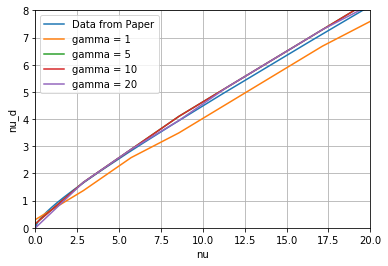

In [56]:
# nu_values = method.stability_boundary_nu_values

# nu_d_values = method.stability_boundary_nu_dipole_values
#nu_and_nu_d_data = nu_and_nu_d_data.values
plt.plot(nu_and_nu_d_data[0,:],nu_and_nu_d_data[1,:])
plt.plot(nu_values[0,:],np.transpose(nu_d_values))

plt.xlabel('nu')
plt.ylabel('nu_d')
plt.grid()
plt.legend(np.append('Data from Paper',['gamma = '+str(s) for s in method.gammas_for_nu_boundary]))
plt.xlim(0,method.nu_range)
plt.ylim(0,8)
plt.show()


In [48]:
method.stability_boundary_D_values
plt.plot(method.gammas,method.boundary_D_values,label= 'stability boundary for $g_{s}$ ='+str(0))
plt.xlabel('$\gamma$')
plt.ylabel('D/'+'$\sqrt{\gamma}$')
plt.grid()
plt.legend()
plt.ylim(0,8)
plt.xlim(self.gamma_range_start_purely_dipolar_stability,self.gamma_range_end_purely_dipolar_stability_high_gamma)
if self.save_boolean:
    plt.savefig(self.path+'/'+'purely dipolar stability boundary'+'.png')
plt.show() ##plots the stability boundary for D against gamma

AttributeError: 'split_step_method' object has no attribute 'stability_boundary_D_values'

In [53]:
method.stability_boundary_D_values

array([75.,  0.])

In [50]:

plt.plot(method.gammas,method.stability_boundary_D_values,label= 'stability boundary for $g_{s}$ ='+str(0))
plt.xlabel('$\gamma$')
plt.ylabel('D/'+'$\sqrt{\gamma}$')
plt.grid()
plt.legend()
plt.ylim(0,np.max(method.Ds))
plt.xlim(method.gamma_range_start_purely_dipolar_stability,method.gamma_range_end_purely_dipolar_stability_high_gamma)
plt.show() ##plots the stability boundary for D against gamma

AttributeError: 'split_step_method' object has no attribute 'gammas'

In [111]:
gamma_res_purely_dipolar_stability_low_gamma_ = 81
gamma_res_purely_dipolar_stability_high_gamma_ = 23
gamma_range_start_purely_dipolar_stability_ = 1
gamma_range_end_purely_dipolar_stability_low_gamma_=20
gamma_range_end_purely_dipolar_stability_high_gamma_ = 140
low_gammas = np.linspace(gamma_range_start_purely_dipolar_stability_,
                                  gamma_range_end_purely_dipolar_stability_low_gamma_,
                                  gamma_res_purely_dipolar_stability_low_gamma_)
high_gammas = np.linspace(gamma_range_end_purely_dipolar_stability_low_gamma_+10,
                                 gamma_range_end_purely_dipolar_stability_high_gamma_,
                                  gamma_res_purely_dipolar_stability_high_gamma_)
gammas = np.append(low_gammas,high_gammas)
gammas

array([  1.    ,   1.2375,   1.475 ,   1.7125,   1.95  ,   2.1875,
         2.425 ,   2.6625,   2.9   ,   3.1375,   3.375 ,   3.6125,
         3.85  ,   4.0875,   4.325 ,   4.5625,   4.8   ,   5.0375,
         5.275 ,   5.5125,   5.75  ,   5.9875,   6.225 ,   6.4625,
         6.7   ,   6.9375,   7.175 ,   7.4125,   7.65  ,   7.8875,
         8.125 ,   8.3625,   8.6   ,   8.8375,   9.075 ,   9.3125,
         9.55  ,   9.7875,  10.025 ,  10.2625,  10.5   ,  10.7375,
        10.975 ,  11.2125,  11.45  ,  11.6875,  11.925 ,  12.1625,
        12.4   ,  12.6375,  12.875 ,  13.1125,  13.35  ,  13.5875,
        13.825 ,  14.0625,  14.3   ,  14.5375,  14.775 ,  15.0125,
        15.25  ,  15.4875,  15.725 ,  15.9625,  16.2   ,  16.4375,
        16.675 ,  16.9125,  17.15  ,  17.3875,  17.625 ,  17.8625,
        18.1   ,  18.3375,  18.575 ,  18.8125,  19.05  ,  19.2875,
        19.525 ,  19.7625,  20.    ,  30.    ,  35.    ,  40.    ,
        45.    ,  50.    ,  55.    ,  60.    ,  65.    ,  70. 

In [49]:
method.stability_boundary_D_values

AttributeError: 'split_step_method' object has no attribute 'stability_boundary_D_values'

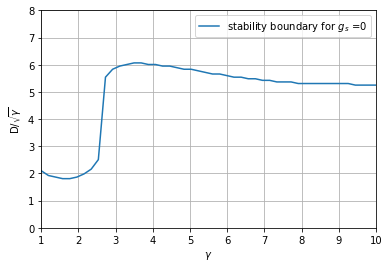

In [24]:
boundary_D_values = method.stability_boundary_D_values
boundary_gamma_values = method.gammas
plt.plot(boundary_gamma_values,boundary_D_values,label= 'stability boundary for $g_{s}$ ='+str(0))
plt.xlabel('$\gamma$')
plt.ylabel('D/'+'$\sqrt{\gamma}$')
plt.grid()
plt.legend()
plt.ylim(0,8)
plt.xlim(1,10)

plt.show() ##plots the stability boundary for D against gamma

In [2]:
method.p_max_dipolar

NameError: name 'method' is not defined

In [14]:
np.linspace(20,250,24)

array([ 20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100., 110., 120.,
       130., 140., 150., 160., 170., 180., 190., 200., 210., 220., 230.,
       240., 250.])